<h1 align="center">
    Players Analysis in SQL and Python
</h1>

<h3 align="center">
    By: Shreeyasha Pandey
</h3>

---

## ☰ Project Overview

This project explores trends and patterns within a Major League Baseball (MLB) player dataset using SQL for data extraction and Python for analysis and visualization.

The analysis focuses on player performance, salary distributions, and position-based trends to uncover key insights relevant for stakeholders such as recruiters, coaches, or sports data analysts.

- **Tools:** PostgreSQL, Python (pandas, matplotlib, seaborn), Jupyter Notebook
- **Topics Covered:** Position breakdowns, salary trends, performance metrics

---

## ☰ Dataset Summary

The data is stored in a PostgreSQL relational database containing tables such as:

- `players`: Biographical information of each MLB player
- `salaries`: Yearly salary records by player and team
- `schools`: School and year attended by player
- `schools_details`: School info (name, city, state, country)

We’ll use SQL to extract and filter relevant slices of the data throughout the notebook.

---


## ☰ Table of Contents
1. [Libraries and Database Setup](#1-libraries-and-database-setup)
2. [Loading the Dataset](#2-loading-the-dataset)
3. [School Analysis](#3-school-analysis)
4. [Concluding Summary](#4-concluding-summary)

---

## 1. Libraries and Database Setup <a class="anchor" id="1-libraries-and-database-setup"></a>

### Import Libraries

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Environment Variables and DB Connection
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Set global seaborn styles
sns.set_style("white", {"axes.spines.right": False, "axes.spines.top": False, 
                            "axes.spines.left": True,"axes.spines.bottom": True})

### Create Database Engine

In [9]:
# Load from .env file
load_dotenv()

# Fetch credentials from environment
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_PORT = os.getenv("DB_PORT", "5432")

# Create SQLAlchemy engine
engine = create_engine(f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

---
## 2. Loading the Dataset <a class="anchor" id="loading-the-dataset"></a>
The following section loads all necessary tables from the PostgreSQL database using SQL queries. Each table is previewed to give a sense of its structure and content.


In [11]:
def load_table(table_name):
    """Load a table from the database into a pandas DataFrame."""
    query = f"SELECT * FROM {table_name};"
    return pd.read_sql(query, con=engine)

In [12]:
# Load the tables
players = load_table("players")
salaries = load_table("salaries")
school_details = load_table("school_details")
schools = load_table("schools")

Next, we'll define a small helper function that formats and displays the first and last few rows of a DataFrame. This allows us to get a quick sense of the table's structure and content throughout the analysis.

In [14]:
def preview_table(df, table_name, n=2):
    """Preview the first and last few rows of a DataFrame with ellipsis in between."""
    ellipsis_row = pd.DataFrame({col: '...' for col in df.columns}, index=['...'])
    
    display(Markdown(f"**Preview of `{table_name}`:**"))
    preview_df = pd.concat([df.head(n), ellipsis_row, df.tail(n)])
    display(preview_df)

---
## 3. School-Based Analysis

In this section, we analyze the role of educational institutions in producing Major League Baseball (MLB) players. Using data from the `schools` and `school_details` tables, we aim to explore patterns in player origins based on schools, states, and time periods. 

In [16]:
# Preview the tables
preview_table(schools, "schools")
preview_table(school_details, "school_details")

**Preview of `schools`:**

,playerid,schoolid,yearid
0,aardsda01,pennst,2001
1,aardsda01,rice,2002
...,...,...,...
17348,zuvelpa01,stanford,1979
17349,zuvelpa01,stanford,1980


**Preview of `school_details`:**

,schoolid,name_full,city,state,country
0,abilchrist,Abilene Christian University,Abilene,TX,USA
1,adelphi,Adelphi University,Garden City,NY,USA
...,...,...,...,...,...
1205,yale,Yale University,New Haven,CT,USA
1206,youngst,Youngstown State University,Youngstown,OH,USA


### 📑 Section Goals:
The following key questions will guide our analysis:

1. **Top Player-Producing Schools:**  
   Identify the top 5 schools that have produced the largest number of MLB players.

2. **Geographic Distribution:**  
   Analyze the locations of these schools — specifically, the states they are based in — to understand regional trends.

3. **Trends in Schools Influence to MLB Talent:**  
   For each decade, determine how many unique schools produced MLB players. This helps capture the breadth of institutions involved across different eras.

4. **Top MLB Producers by Decade:**  
   Identify the top 3 schools that produced the most players in each decade. This will highlight how school influence may have shifted over time.

This analysis will help uncover historical and regional influences in player development and could potentially inform scouting strategies or historical retrospectives.

### 3.1 Top Player-Producing Schools

***SQL Query:***
```sql
SELECT sd.name_full AS school_name, s.players_produced
FROM school_details AS sd
RIGHT JOIN (
	SELECT schoolid, COUNT(DISTINCT playerid) AS players_produced
	FROM schools
	GROUP BY schoolid) AS s
ON sd.schoolid = s.schoolid
ORDER BY s.players_produced DESC
LIMIT 5;


***Query Result:***

In [20]:
# Hidden query execution
query = """
    SELECT sd.name_full AS school_name, s.players_produced
    FROM school_details AS sd
    RIGHT JOIN (
    	SELECT schoolid, COUNT(DISTINCT playerid) AS players_produced
    	FROM schools
    	GROUP BY schoolid) AS s
    ON sd.schoolid = s.schoolid
    ORDER BY s.players_produced DESC
    LIMIT 5;
"""

In [21]:
# Run query and preview result
df_top_five_schools = pd.read_sql(query, con=engine)
df_top_five_schools

,school_name,players_produced
0,University of Texas at Austin,107
1,University of Southern California,105
2,Arizona State University,101
3,Stanford University,86
4,University of Michigan,76


**💡 Insights:**

These schools stand out as major talent pipelines for Major League Baseball, with UT Austin and USC leading the list.

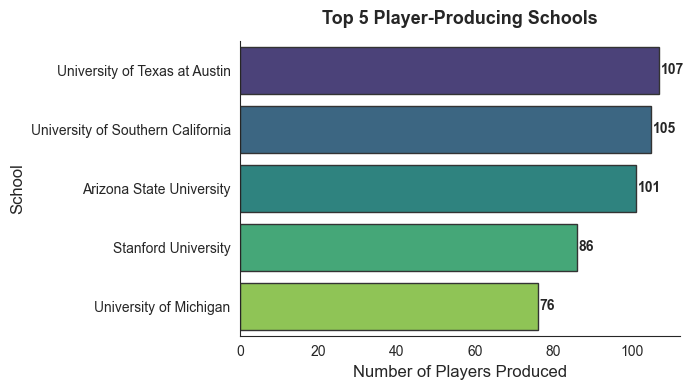

In [23]:
plt.figure(figsize=(7, 4))
sns.barplot(data=df_top_five_schools, x="players_produced", y="school_name",
            hue="school_name", palette="viridis", edgecolor=".2")

# Add bar labels
for index, value in enumerate(df_top_five_schools["players_produced"]):
    plt.text(value + 0.5, index, str(value), va='center', fontsize=10, fontweight='semibold')

# Axis labels & title
plt.xlabel("Number of Players Produced", fontsize=12)
plt.ylabel("School", fontsize=12)
plt.title("Top 5 Player-Producing Schools", fontsize=13, weight='bold', pad=12)

plt.tight_layout()
plt.show()

---
### 3.2 Geographic Distribution
In this section, we analyze the geographic distribution of MLB players based on the states where they attended school. The goal is to identify which states have historically produced the highest number of professional baseball players.

***SQL Query:***
```sql
SELECT sd.state, COUNT(DISTINCT playerid) AS num_players
FROM schools AS s
LEFT JOIN school_details AS sd
ON s.schoolid = sd.schoolid
GROUP BY sd.state
ORDER BY num_players DESC
LIMIT 3;

***Query Result:***

In [26]:
# Hidden query execution
query = """
    SELECT sd.state, COUNT(DISTINCT playerid) AS num_players
    FROM schools AS s
    LEFT JOIN school_details AS sd
    ON s.schoolid = sd.schoolid
    GROUP BY sd.state
    ORDER BY num_players DESC
    LIMIT 3;
"""

In [27]:
# Run query and preview result
df_top_three_states = pd.read_sql(query, con=engine)
df_top_three_states

,state,num_players
0,CA,1247
1,TX,536
2,FL,473


**💡 Insights:**

California stands out as the top contributor for producing MLB players (1,247), with Texas (536) and Florida (473) trailing behind. The substantial gap suggests California as a stronger baseball pipeline.

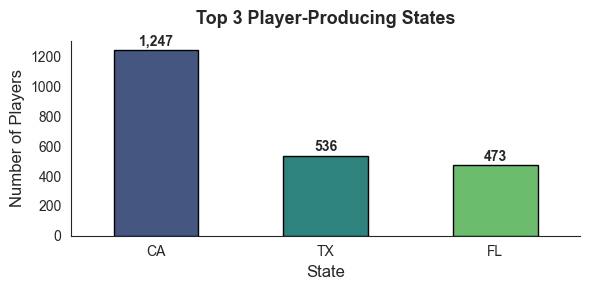

In [111]:
plt.figure(figsize=(6, 3))
sns.barplot(data=df_top_three_states, x="state", y="num_players",
            hue='state', palette="viridis", 
            edgecolor="black", width=0.5)

# Annotate bars
for index, value in enumerate(df_top_three_states["num_players"]):
    plt.text(x=index, y=value + 10, s=f"{value:,}", ha="center", va="bottom", fontsize=10, weight='bold')

# Axis & title
plt.title("Top 3 Player-Producing States", fontsize=13, weight='bold', pad=12)
plt.xlabel("State", fontsize=12)
plt.ylabel("Number of Players", fontsize=12)

plt.tight_layout()
plt.show()

---
### 3.3 Trends in Schools Influence to MLB Talent
We now examine how the number of unique schools contributing MLB players has changed across decades. This helps highlight how the talent pipeline has expanded or concentrated over time.

***SQL Query:***
```sql
SELECT FLOOR(yearid/10) * 10 AS decade, COUNT(DISTINCT schoolid) AS num_schools
FROM schools
GROUP BY decade
ORDER BY decade;

***Query Result:***

In [32]:
# Hidden query execution
query = """
    SELECT FLOOR(yearid/10) * 10 AS decade, COUNT(DISTINCT schoolid) AS num_schools
    FROM schools
    GROUP BY decade
    ORDER BY decade;
"""

In [33]:
# Run query and preview result
df_school_decades = pd.read_sql(query, con=engine)
preview_table(df_school_decades, "df_school_decades")

**Preview of `df_school_decades`:**

,decade,num_schools
0,1860.0,2
1,1870.0,14
...,...,...
14,2000.0,372
15,2010.0,57


**💡 Insights:**

- From the 1860s through the early 20th century, there was a **steady rise** in the number of schools contributing players to Major League Baseball.
  
- The trend **accelerated sharply** beginning in the 1960s, reaching a peak in the 1990s with nearly 500 schools represented.

- After the 1990s, there is a **notable decline** in the number of contributing schools. It is possible that fewer schools now produce more players.

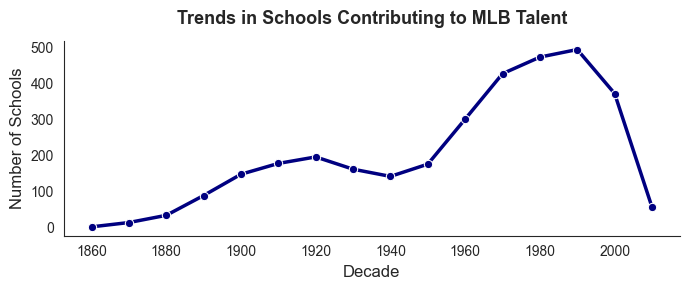

In [35]:
plt.figure(figsize=(7, 3))
sns.lineplot(data=df_school_decades, x='decade', y='num_schools', marker='o', linewidth=2.5, color='navy')

# Axis and Title
plt.title("Trends in Schools Contributing to MLB Talent", fontsize=13, weight='bold', pad=12)
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Number of Schools", fontsize=12)

plt.tight_layout()
plt.show()

---
### 3.4 Top MLB Producers by Decade
In this section, we examine how the **most influential schools in producing MLB players** have changed over time. By grouping data by decade and identifying the top school for each, we can explore shifts in talent pipelines and institutional influence throughout baseball history.

***SQL Query:***
```sql
WITH school_by_decade AS (
	 SELECT *, FLOOR(yearid/10) * 10 AS decade
	 FROM schools
	 ORDER BY decade
),
school_ranking AS (
	 SELECT decade, schoolid, COUNT(DISTINCT playerid) AS num_players,
			ROW_NUMBER() OVER (PARTITION BY decade ORDER BY COUNT(DISTINCT playerid) DESC) AS school_rank
	 FROM school_by_decade
	 GROUP BY decade, schoolid
)

SELECT CONCAT(sr.decade, 's') AS decade, 
	   sd.name_full AS school_name, sr.num_players AS num_players
FROM school_ranking AS sr
LEFT JOIN school_details AS sd ON sr.schoolid = sd.schoolid
WHERE school_rank =1
ORDER BY sr.decade DESC;

***Query Result:***

In [38]:
# Hidden query execution
query = """
WITH school_by_decade AS (
	 SELECT *, FLOOR(yearid/10) * 10 AS decade
	 FROM schools
	 ORDER BY decade
),
school_ranking AS (
	 SELECT decade, schoolid, COUNT(DISTINCT playerid) AS num_players,
			ROW_NUMBER() OVER (PARTITION BY decade ORDER BY COUNT(DISTINCT playerid) DESC) AS school_rank
	 FROM school_by_decade
	 GROUP BY decade, schoolid
)

SELECT CONCAT(sr.decade, 's') AS decade, 
	   sd.name_full AS school_name, sr.num_players AS num_players
FROM school_ranking AS sr
LEFT JOIN school_details AS sd ON sr.schoolid = sd.schoolid
WHERE school_rank =1
ORDER BY sr.decade DESC;
"""

In [39]:
# Run query and preview result
df_top_school_by_decade = pd.read_sql(query, con=engine)
preview_table(df_top_school_by_decade, "df_top_school_by_decade")

**Preview of `df_top_school_by_decade`:**

,decade,school_name,num_players
0,2010s,University of Florida,5
1,2000s,Arizona State University,23
...,...,...,...
14,1870s,Brown University,3
15,1860s,Fordham University,1


**💡 Insights:**

- **Arizona State University** stands out as a **dominant contributor** to MLB player production during the mid-to-late 20th century, topping the 1960s, 1970s, and 2000s.
- The University of Southern California also had a strong presence in the mid-1900s.
- In earlier decades, elite Northeastern schools such as Yale, Brown, and Fordham led the way, highlighting a historical shift in talent pipelines from the Northeast to the West and South over time.

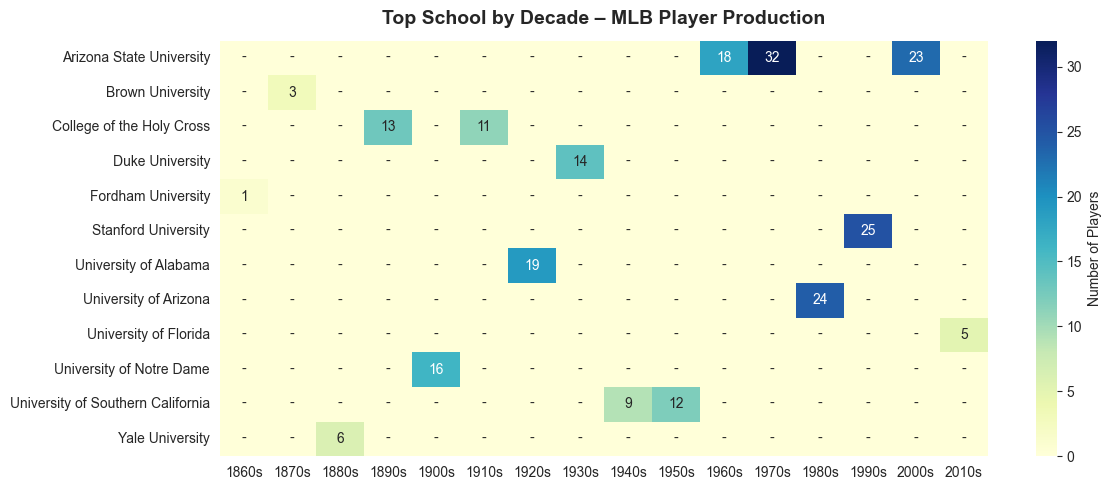

In [41]:
# Pivot the data to create a matrix of schools (rows) vs. decades (columns)
heatmap_df = df_top_school_by_decade.pivot_table(index="school_name", columns="decade", 
                                                 values="num_players", fill_value=0)
heatmap_df = heatmap_df.astype(int)

# Create a heatmap to show player production across decades
plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_df, annot=heatmap_df.copy().replace(0, '-'), fmt='', cmap="YlGnBu", cbar_kws={'label': 'Number of Players'})

plt.title("Top School by Decade – MLB Player Production", fontsize=14, weight='bold', pad=12)
plt.xlabel("")
plt.ylabel("")

plt.tight_layout()
plt.show()

---
## 4. Salary Analysis
In this section, we explore the salary landscape across MLB teams to uncover spending patterns and financial dominance over time.

In [43]:
preview_table(salaries, "salaries")

**Preview of `salaries`:**

,yearid,teamid,lgid,playerid,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
...,...,...,...,...,...
24756,2014,WAS,NL,zimmejo02,7500000
24757,2014,WAS,NL,zimmery01,14000000


### 📑 Section Goals:

1. **Top 20% High-Spending Teams:**  
   Identify the top 20% of teams based on their average annual salary spending, revealing the most financially aggressive franchises.

2. **Cumulative Spending Over Time:**  
   Track the cumulative salary expenditure for each team across seasons, providing insights into long-term strategies.

3. **Threshold of \$1 Billion Cumulative Spend:**  
   Determine the first year each team’s cumulative salary surpassed \$1 billion, spotlighting franchises with sustained high spending over time.

This investigation sheds light on how financial investments vary across franchises and how long-term spending correlates with broader league dynamics.

### 4.1 Top 20% High-Spending Teams
This gives insight into which franchises have consistently invested the most in player compensation over the years.

***SQL Query:***
```sql
-- Calculate total salary spending per year for each team
CREATE TEMPORARY TABLE IF NOT EXISTS team_annual AS (
	SELECT teamid, yearid, SUM(salary) AS total_spend_yr
	FROM salaries
	GROUP BY teamid, yearid
	ORDER BY teamid, yearid);

-- Segment teams into quintiles and compute average yearly spending
WITH avg_spend_tiles AS (
	SELECT teamid,
			AVG(total_spend_yr) AS avg_yearly_spend,
			NTILE(5) OVER (ORDER BY ROUND(AVG(total_spend_yr)) DESC) AS spend_pct 
	FROM team_annual
	GROUP BY teamid)

-- Extract the top quintile (top 20%)
SELECT teamid as team, ROUND(avg_yearly_spend / 1000000, 1) AS avg_spend_in_mil
FROM avg_spend_tiles
WHERE spend_pct = 1;

In [69]:
# Hidden query execution
query = """
CREATE TEMPORARY TABLE IF NOT EXISTS team_annual AS (
	SELECT teamid, yearid, SUM(salary) AS total_spend_yr
	FROM salaries
	GROUP BY teamid, yearid
	ORDER BY teamid, yearid);

WITH avg_spend_tiles AS (
	SELECT teamid,
			AVG(total_spend_yr) AS avg_yearly_spend,
			NTILE(5) OVER (ORDER BY ROUND(AVG(total_spend_yr)) DESC) AS spend_pct
	FROM team_annual
	GROUP BY teamid)

SELECT teamid AS team, ROUND(avg_yearly_spend / 1000000, 1) AS avg_spend_in_mil
FROM avg_spend_tiles
WHERE spend_pct = 1;
"""

In [72]:
# Run query and preview result
df_top_20_pct = pd.read_sql(query, con=engine)
df_top_20_pct

,team,avg_spend_in_mil
0,SFG,143.5
1,LAA,118.5
2,NYA,109.4
3,BOS,81.1
4,LAN,74.6
5,WAS,71.5
6,ARI,71.2
7,PHI,66.1


**💡 Insights:**

- **Arizona State University** stands out as a **dominant contributor** to MLB player production during the mid-to-late 20th century, topping the 1960s, 1970s, and 2000s.
- The University of Southern California also had a strong presence in the mid-1900s.
- In earlier decades, elite Northeastern schools such as Yale, Brown, and Fordham led the way, highlighting a historical shift in talent pipelines from the Northeast to the West and South over time.

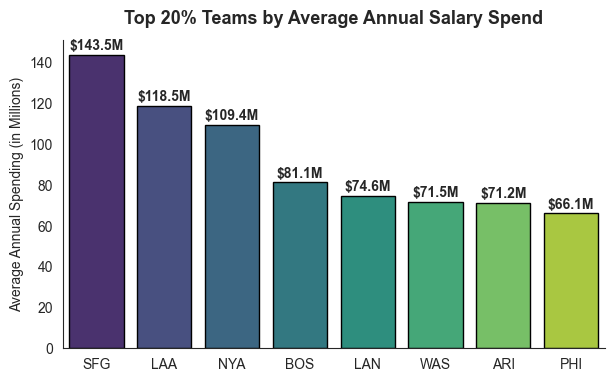

In [115]:
plt.figure(figsize=(7, 4))
sns.barplot(data=df_top_20_pct, x='team', y='avg_spend_in_mil', hue='team', palette='viridis', edgecolor='black')

# Add value labels
for index, value in enumerate(df_top_20_pct["avg_spend_in_mil"]):
    plt.text(x=index, y=value + 1, s=f"${value:.1f}M", ha='center', va="bottom", fontsize=10, weight='bold')
    
# Title and labels
plt.title('Top 20% Teams by Average Annual Salary Spend', fontsize=13, fontweight='bold', pad=12)
plt.xlabel('')
plt.ylabel('Average Annual Spending (in Millions)')

plt.show()

## 4. Concluding Summary

Refactor Notes:
```
with open("top_spenders.sql") as f:
    query = f.read()

df_top_20_pct = pd.read_sql(query, con=engine)
display(df_top_20_pct)
